# Workshop 1: Machine Learning Foundations
## Intro to Data Science Tools for Building Industry Professionals
## Presentation 1: Regression Techniques for M&V from Interval Meter Data

In [1]:
# May need to install some things upon first use
#!pip install featuretools
#!pip install doubt

In [2]:
import os

import numpy as np
import pandas as pd

from matplotlib import gridspec
import matplotlib.pyplot as plt

import featuretools as ft
from featuretools.primitives import Lag, RollingMean, RollingMin, RollingMax, RollingTrend
from featuretools.selection import remove_highly_correlated_features

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate

from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor

from xgboost import XGBRegressor

from doubt import Boot

## 1. Load the data and perform some checks.

In [3]:
# Load the data into a Pandas data frame
url = "https://raw.githubusercontent.com/gpavlak/ashrae-ml-fdn/main/1%20Whole%20Building%20Electricity%20Prediction/Chicago2021_dataset211231V4.csv"
df = pd.read_csv(url)
df.head()

,date_time_utc,temperature,dew_point,relative_humidity,cloud_cover,direct_normal_radiation,wet_bulb,Occupancy_HB,kWh_HB
0,6/2/2021 6:00,62,56,80,88,0,59,0.00,0.454
1,6/2/2021 7:00,61,54,78,88,0,57,0.00,0.438
2,6/2/2021 8:00,60,54,80,100,0,57,0.00,0.436
3,6/2/2021 9:00,60,54,80,100,7,57,0.00,0.439
4,6/2/2021 10:00,59,54,83,88,108,56,0.02,0.489


In [4]:
# Convert from UTC to local time.
df.insert(loc=0,
          column = 'time_id',
          value = pd.to_datetime(df['date_time_utc']) - np.timedelta64(5,'h')
          )
df.head()

,time_id,date_time_utc,temperature,dew_point,relative_humidity,cloud_cover,direct_normal_radiation,wet_bulb,Occupancy_HB,kWh_HB
0,2021-06-02 01:00:00,6/2/2021 6:00,62,56,80,88,0,59,0.00,0.454
1,2021-06-02 02:00:00,6/2/2021 7:00,61,54,78,88,0,57,0.00,0.438
2,2021-06-02 03:00:00,6/2/2021 8:00,60,54,80,100,0,57,0.00,0.436
3,2021-06-02 04:00:00,6/2/2021 9:00,60,54,80,100,7,57,0.00,0.439
4,2021-06-02 05:00:00,6/2/2021 10:00,59,54,83,88,108,56,0.02,0.489


In [5]:
# Looks good, so drop forecast_time_UTC
df = df.drop(labels=['date_time_utc'], axis='columns')

# Also insert separate row id column. This will be helpful for FeatureTools later.
df['id'] = range(len(df.index))
df.head()

,time_id,temperature,dew_point,relative_humidity,cloud_cover,direct_normal_radiation,wet_bulb,Occupancy_HB,kWh_HB,id
0,2021-06-02 01:00:00,62,56,80,88,0,59,0.00,0.454,0
1,2021-06-02 02:00:00,61,54,78,88,0,57,0.00,0.438,1
2,2021-06-02 03:00:00,60,54,80,100,0,57,0.00,0.436,2
3,2021-06-02 04:00:00,60,54,80,100,7,57,0.00,0.439,3
4,2021-06-02 05:00:00,59,54,83,88,108,56,0.02,0.489,4


In [6]:
# Let's double check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2904 entries, 0 to 2903
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time_id                  2904 non-null   datetime64[ns]
 1   temperature              2904 non-null   int64         
 2   dew_point                2904 non-null   int64         
 3   relative_humidity        2904 non-null   int64         
 4   cloud_cover              2904 non-null   int64         
 5   direct_normal_radiation  2904 non-null   int64         
 6   wet_bulb                 2904 non-null   int64         
 7   Occupancy_HB             2904 non-null   float64       
 8   kWh_HB                   2904 non-null   float64       
 9   id                       2904 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(7)
memory usage: 227.0 KB


In [7]:
# We will want many of these to be treated as continuous variables, so let's 
# convert to floats.

# Set the correct data types
convert_dict = {'temperature': float,
                'dew_point': float,
                'relative_humidity': float,
                'cloud_cover': float,
                'direct_normal_radiation': float,
                'wet_bulb': float,
                'Occupancy_HB': float,
                'kWh_HB': float,
                'id': int
                }
 
df =df.astype(convert_dict)
print(df.dtypes)

time_id                    datetime64[ns]
temperature                       float64
dew_point                         float64
relative_humidity                 float64
cloud_cover                       float64
direct_normal_radiation           float64
wet_bulb                          float64
Occupancy_HB                      float64
kWh_HB                            float64
id                                  int64
dtype: object


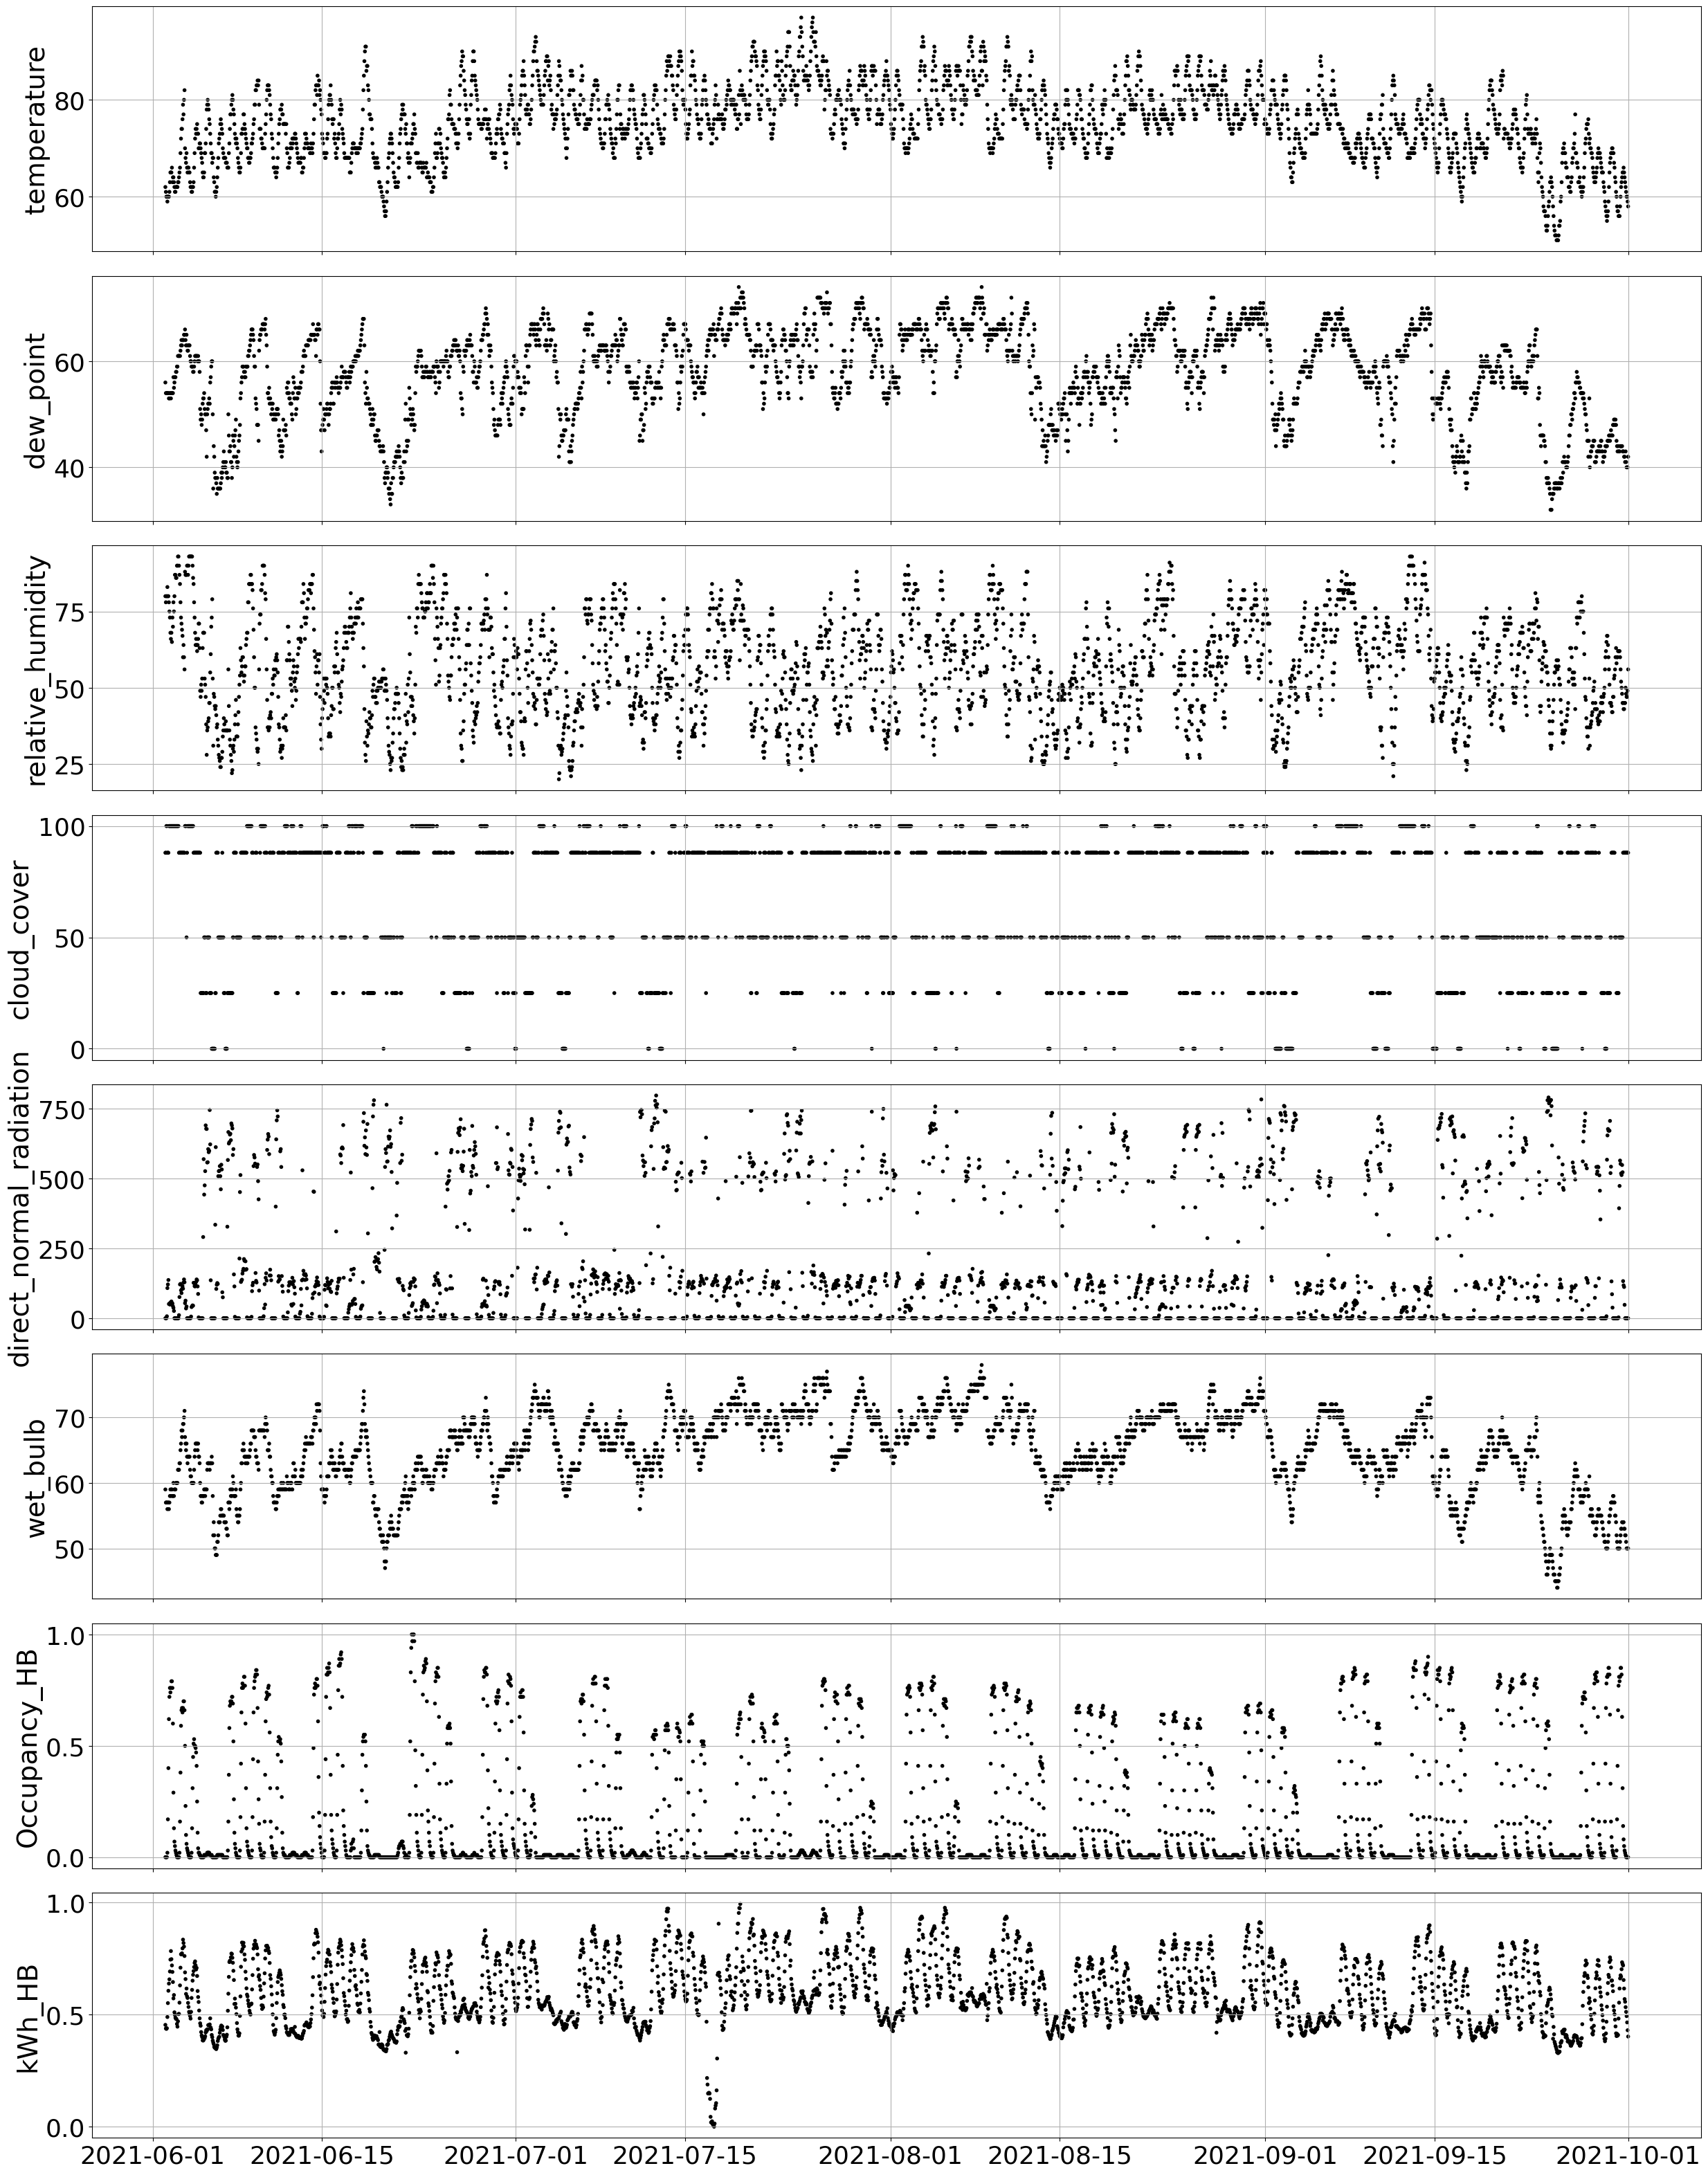

In [8]:
# The data set is not too large, so let's do a quick visual check.

# Get the columns to plot
cols = df.columns.to_list()
cols = [x for x in cols if x not in ['time_id', 'id'] ]

# Set some plotting parameters
fig = plt.figure(figsize=(30,5*len(cols)))
gs = gridspec.GridSpec(len(cols), 1, height_ratios=[1]*len(cols)) 
plt.subplots_adjust(hspace=0.1)

# Generate a subplot for each column in the data set
for n, c in enumerate(cols):

    # Subplot axes
    if n == 0:
        ax = [plt.subplot(gs[n])]
    else:
        ax.append(plt.subplot(gs[n], sharex = ax[0]))

    ax[n].grid(True)
    ax[n].scatter(df['time_id'], df[c], color = 'k', linestyle = '', marker = '.',alpha=1)
    ax[n].set_ylabel(c, fontsize=28)
    ax[n].tick_params(axis='x', labelsize=26)
    ax[n].tick_params(axis='y', labelsize=26)

    # Only apply x-axis tick labels to the last subplot
    if n < len(cols)-1:
        plt.setp(ax[n].get_xticklabels(), visible=False)

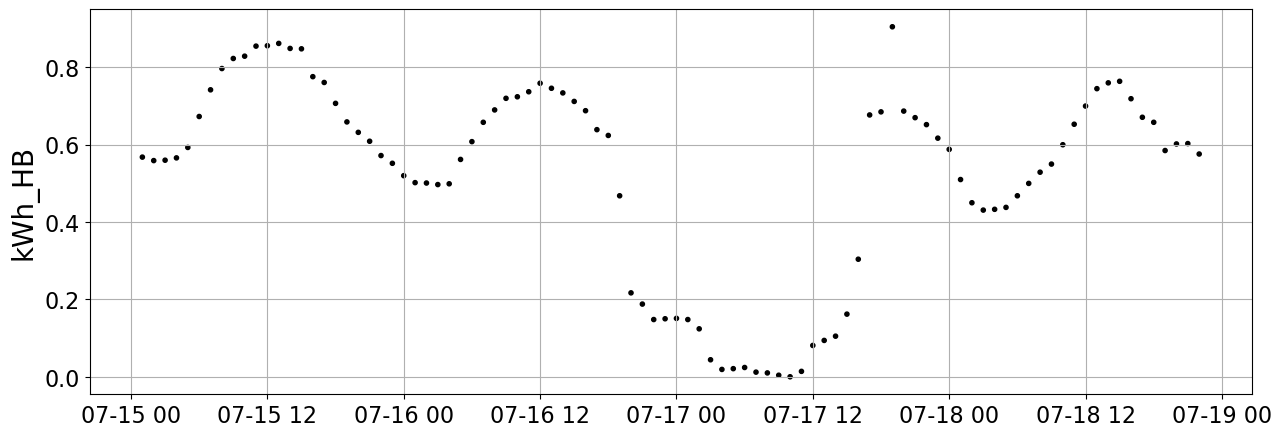

In [9]:
# Looks like some anomalous behavior in the mid July kWh. Let's investigate.
t_slice = df.index[(df['time_id'] > '2021-07-15 00:00:00') & 
                   (df['time_id'] < '2021-07-18 23:00:00')]

# Set some plotting parameters
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax = plt.subplot(gs[0])

ax.grid(True)
ax.scatter(df['time_id'][t_slice], df['kWh_HB'][t_slice], color = 'k', linestyle = '', marker = '.',alpha=1)
ax.set_ylabel('kWh_HB')
ax.set_ylabel(c, fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

In [10]:
# Let's simply drop those hours from the data set for now.
rows_to_drop = df.index[(df['time_id'] > '2021-07-16 18:00:00') & 
                   (df['time_id'] < '2021-07-17 18:00:00')].to_list()

df = df.drop(labels=rows_to_drop, axis='index')

## 2. Split the data into train and test sets.
We use the **training** set for trying out various models, and reserve the **test**
set for computing performance metrics on the final model(s). This helps give
a better estimate of how the model will perform when given new data, which
is our ultimate goal.

In [11]:
# Split the data into test and train
train_ids = df.index[df['time_id'] < '2021-08-01 00:00:00']
test_ids = df.index[(df['time_id'] >= '2021-08-01 00:00:00') & 
                    (df['time_id'] <= '2021-08-31 23:00:00')]

y_train = df[['kWh_HB']].loc[train_ids]
y_test = df[['kWh_HB']].loc[test_ids]

# Drop the y column and some redundant/highly correlated weather variables.
X = df.drop(labels=['kWh_HB','relative_humidity','dew_point','cloud_cover'], axis='columns')
X_train = X.loc[train_ids]
X_test = X.loc[test_ids]

# Also, keep a copy of the original id to time_id mapping.
ids = pd.DataFrame()
ids['id'] = X['id']
ids['time_id'] = X['time_id']

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1416 entries, 0 to 1438
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time_id                  1416 non-null   datetime64[ns]
 1   temperature              1416 non-null   float64       
 2   direct_normal_radiation  1416 non-null   float64       
 3   wet_bulb                 1416 non-null   float64       
 4   Occupancy_HB             1416 non-null   float64       
 5   id                       1416 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 77.4 KB


## 3. Engineer features and explore models.

In [12]:
# Package the data for use in FeatureTools
es = ft.EntitySet(id = 'BldDataTrain')
es.add_dataframe(dataframe_name = 'wea_and_occ',
                 dataframe = X_train,
                 index = 'id',
                 time_index = 'time_id'
                 )
#es['wea_and_occ'].info()

Entityset: BldDataTrain
  DataFrames:
    wea_and_occ [Rows: 1416, Columns: 6]
  Relationships:
    No relationships

In [13]:
# Feature Engineering via FeatureTools
# Create some new time-based features including lags and rolling means.
datetime_primitives = ["Hour"]#, "Weekday", "IsWeekend"]

gap, window_length = 1, 12
delaying_primitives = [Lag(periods=i + gap) for i in range(window_length)]

win_len = [3,6,9,12]
rolling_mean_primitives = [
    RollingMean(window_length=w, gap=1, min_periods=w) for w in win_len
]

feature_mat_train, feature_defs_train = ft.dfs(
    entityset=es,
    target_dataframe_name="wea_and_occ",
    trans_primitives=(
        datetime_primitives
 #       + delaying_primitives
 #       + rolling_mean_primitives
    ),
    max_depth=1,
)
feature_mat_train.head()

,temperature,direct_normal_radiation,wet_bulb,Occupancy_HB,HOUR(time_id)
id,,,,,
0,62.0,0.0,59.0,0.00,1
1,61.0,0.0,57.0,0.00,2
2,60.0,0.0,57.0,0.00,3
3,60.0,7.0,57.0,0.00,4
4,59.0,108.0,56.0,0.02,5


In [14]:
# Start by removing highly correlated features
fm_train, features_train = remove_highly_correlated_features(
    feature_mat_train, features=feature_defs_train, pct_corr_threshold=0.95)
set(feature_defs_train) - set(features_train)

# Encode feature matrix to be compatible with various ML algorithms
# https://featuretools.alteryx.com/en/latest/resources/frequently_asked_questions.html#Modeling
fm_train.ww.init()
X_enc_train, feature_enc_train = ft.encode_features(fm_train, features_train)
X_enc_train.head()

,temperature,direct_normal_radiation,wet_bulb,Occupancy_HB,HOUR(time_id) = 18,HOUR(time_id) = 23,HOUR(time_id) = 22,HOUR(time_id) = 21,HOUR(time_id) = 20,HOUR(time_id) = 19,HOUR(time_id) = 17,HOUR(time_id) = 16,HOUR(time_id) = 15,HOUR(time_id) = 14,HOUR(time_id) is unknown
id,,,,,,,,,,,,,,,
0,62.0,0.0,59.0,0.00,False,False,False,False,False,False,False,False,False,False,True
1,61.0,0.0,57.0,0.00,False,False,False,False,False,False,False,False,False,False,True
2,60.0,0.0,57.0,0.00,False,False,False,False,False,False,False,False,False,False,True
3,60.0,7.0,57.0,0.00,False,False,False,False,False,False,False,False,False,False,True
4,59.0,108.0,56.0,0.02,False,False,False,False,False,False,False,False,False,False,True


In [15]:
# Can save the features if you would like
#ft.save_features(feature_enc_train, "feat_defs_june_voting_reg.json")

In [16]:
# Find the rows to drop that have NaNs from variable lagging
rows_to_drop = X_enc_train.index[X_enc_train.isna().any(axis=1)]

# Drop rows for X and Y data
X_enc_train = X_enc_train.drop(labels = rows_to_drop, axis='index')
y_train = y_train.drop(labels = rows_to_drop, axis='index')

In [17]:
# Functions for evaluating models with cross-validation and hyperparameter tuning
def evaluate_nested(model, param_grid, X, y, cv):

    # Cross-validated grid-search for parameter tuning (i.e., inner CV loop)
    grid = GridSearchCV(model, param_grid, cv=cv,
                        n_jobs=-1, scoring="neg_root_mean_squared_error")
    
    # Outer Cross-validation loop
    cv_results = cross_validate(
        grid, X, y, cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )

    # Extract and print some of the outer CV metrics
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2s = cv_results["test_r2"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"R Squared: {r2s.mean():.3f} +/- {r2s.std():.3f}"
    )

In [18]:
# Create and evaluate a Ridge Regression Model using nested cross-validation
ridge_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ridge', Ridge())]
).set_output(transform="pandas")

ridge_param_grid = {
    'ridge__alpha': np.logspace(-6, 6, 25)
}

ts_cv = TimeSeriesSplit(n_splits=5)

evaluate_nested(ridge_pipeline, ridge_param_grid, X_enc_train, y_train, cv=ts_cv)

Mean Absolute Error:     0.051 +/- 0.010
Root Mean Squared Error: 0.063 +/- 0.012
R Squared: 0.792 +/- 0.060


In [19]:
# Create and evaluate an XGBoost Regression Model using nested cross-validation
xgb_pipeline = Pipeline([
    ('model', XGBRegressor())
]).set_output(transform="pandas")

xgb_param_grid = {
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500, 1000]
}

ts_cv = TimeSeriesSplit(n_splits=5)

evaluate_nested(xgb_pipeline, xgb_param_grid, X_enc_train, y_train, cv=ts_cv)

Mean Absolute Error:     0.043 +/- 0.013
Root Mean Squared Error: 0.057 +/- 0.016
R Squared: 0.828 +/- 0.078


In [20]:
# Based on performance metrics could loop back to feature engineering and try
# to add/remove different features to improve the fit.

## 4. Train and evaluate final models.

In [21]:
# After feature engineering complete, train final models on full training data

# Train Ridge
# Using GridSearchCV for consistency but could also use RidgeCV()
ridge = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=ts_cv,
                n_jobs=-1, scoring="neg_root_mean_squared_error")
ridge.fit(X_enc_train, y_train)

# Train XGB
xgb = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=ts_cv,
                n_jobs=-1, scoring="neg_root_mean_squared_error")
xgb.fit(X_enc_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 3, 5, 7, 10],
                         'model__n_estimators': [10, 100, 500, 1000]},
             scoring='neg_root_mean_squared_error')

In [22]:
# Create EntitySet for Test Data
es_test = ft.EntitySet(id = 'BldDataTest')
es_test.add_dataframe(dataframe_name = 'wea_and_occ',
                      dataframe = X_test,
                      index = 'id',
                      time_index = 'time_id'
                      )

# Calculate features for test set
X_enc_test = ft.calculate_feature_matrix(feature_enc_train, es_test)

# Find the rows to drop that have NaNs from variable lagging
rows_to_drop = X_enc_test.index[X_enc_test.isna().any(axis=1)]

# Drop rows for X and Y data
X_enc_test = X_enc_test.drop(labels = rows_to_drop, axis='index')
y_test = y_test.drop(labels = rows_to_drop, axis='index')

# Also need to ensure that the column order in test is same as train
X_enc_test = X_enc_test.reindex(X_enc_train.columns, axis=1)
X_enc_test.columns == X_enc_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [23]:
# Function to get test predictions and stats for each of the final models
# P.I.'s generated using bootstrap implemented in Doubt package
# [1]: Friedman, J., Hastie, T., & Tibshirani, R. (2001). The elements of
#             statistical learning (Vol. 1, No. 10). New York: Springer series in
#             statistics.
# [2]: Kumar, S., & Srivistava, A. N. (2012). Bootstrap prediction intervals in
#             non-parametric regression with applications to anomaly detection.
# [3]: https://saattrupdan.github.io/2020-03-01-bootstrap-prediction
def test_preds_and_stats(reg_mod, mod_name, Xtr, ytr, Xte, yte=[]):
    
    # Predict test data with bootstrap P.I.'s
    m = Boot(reg_mod)
    m.fit(Xtr, ytr)
    pred = m.predict(Xte, uncertainty=0.05)
    
    # Unpack
    low, pre, upp = [], [], []
    for r in range(len(pred[1])):
        low.append(pred[1][r][0])
        pre.append(pred[0][r])
        upp.append(pred[1][r][1])

    # Compute metrics
    stats = []

    if len(yte) != 0:

        stats.append(
            pd.DataFrame(index=pd.Index([mod_name]),
                    data={"RMSE": mean_squared_error(yte, pre)**0.5,
                        "MAE": mean_absolute_error(yte, pre),
                        "R2": r2_score(yte, pre)}
                        )
        )

    return low, pre, upp, stats

In [24]:
# Testing the final Ridge model.
ridge_f = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ridge', Ridge(alpha=ridge.best_params_['ridge__alpha']))
    ]).set_output(transform="pandas")

ridge_res = test_preds_and_stats(ridge_f, 'Ridge',
                                 X_enc_train.reset_index(drop=True),       #<-- Boot seems to prefer the index to start at zero
                                 y_train['kWh_HB'].reset_index(drop=True), #<-- Boot seems to prefer a Series
                                 X_enc_test.reset_index(drop=True),
                                 y_test['kWh_HB'].reset_index(drop=True))

# Testing the final XGB model.
xgb_f = Pipeline([
    ('xgb', XGBRegressor(max_depth=xgb.best_params_['model__max_depth'],
                         n_estimators=xgb.best_params_['model__n_estimators']))
                         ]).set_output(transform="pandas")

xgb_res = test_preds_and_stats(xgb_f, 'XGBoost',
                               X_enc_train.reset_index(drop=True),
                               y_train['kWh_HB'].reset_index(drop=True), 
                               X_enc_test.reset_index(drop=True),
                               y_test['kWh_HB'].reset_index(drop=True))

# Also try a VotingRegressor
vote = VotingRegressor([('ridge', ridge_f), ('xgb', xgb_f)])

vote_res = test_preds_and_stats(vote, 'VotingReg',
                                X_enc_train.reset_index(drop=True),
                                y_train['kWh_HB'].reset_index(drop=True), 
                                X_enc_test.reset_index(drop=True),
                                y_test['kWh_HB'].reset_index(drop=True))

res_list = [ridge_res, xgb_res, vote_res]

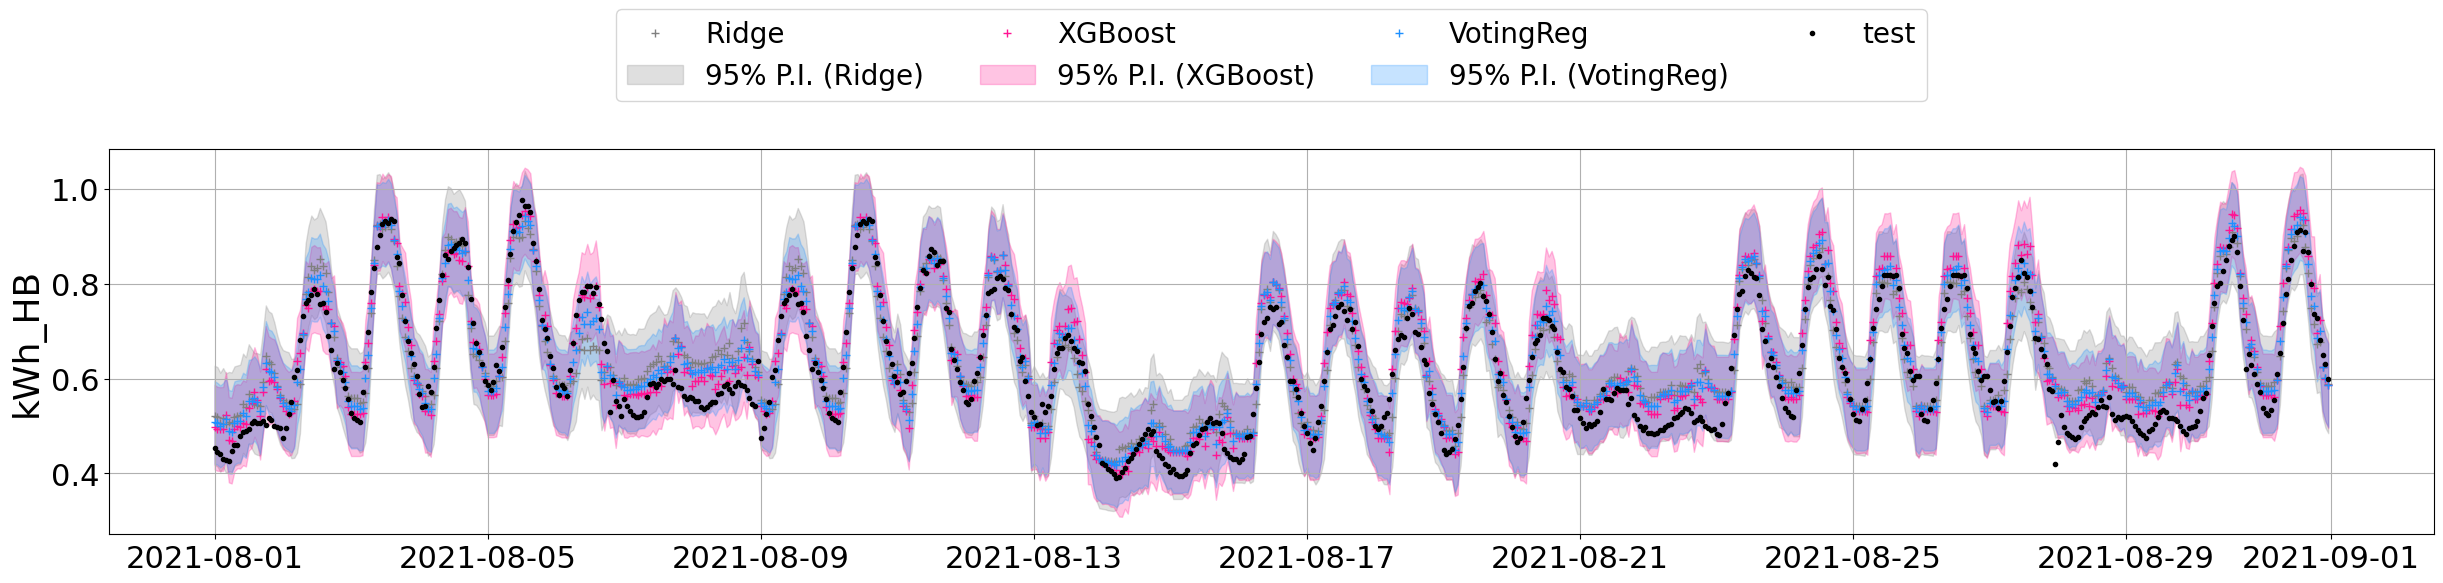

In [25]:
fig = plt.figure(figsize=(30,5))
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])

plt.subplots_adjust(hspace=0.1)

ax0.grid(True)

clrs = ['gray','deeppink','dodgerblue']

# Plot test predictions
ct=0
for r in res_list:
    lab = r[3][0].index[0]
    ax0.plot(ids['time_id'][y_test.index], r[1], color = clrs[ct], linestyle = '', marker = '+', label=lab)
    ax0.fill_between(ids['time_id'][y_test.index],r[0],r[2], label="95% P.I. ("+lab+")", color=clrs[ct], alpha=0.25)
    ct+=1

# Test data
ax0.plot(ids['time_id'][y_test.index], y_test, color = 'k', linestyle = '', marker = '.',alpha=1, label="test")

ax0.set_ylabel('kWh_HB')
ax0.set_ylabel(c, fontsize=26)
ax0.tick_params(axis='x', labelsize=22)
ax0.tick_params(axis='y', labelsize=22)
ax0.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4, fontsize=20)

In [26]:
# Print summary stats
pd.concat([r[3][0] for r in res_list])

,RMSE,MAE,R2
Ridge,0.051064,0.041779,0.850729
XGBoost,0.042067,0.034564,0.898696
VotingReg,0.042690,0.034849,0.895674


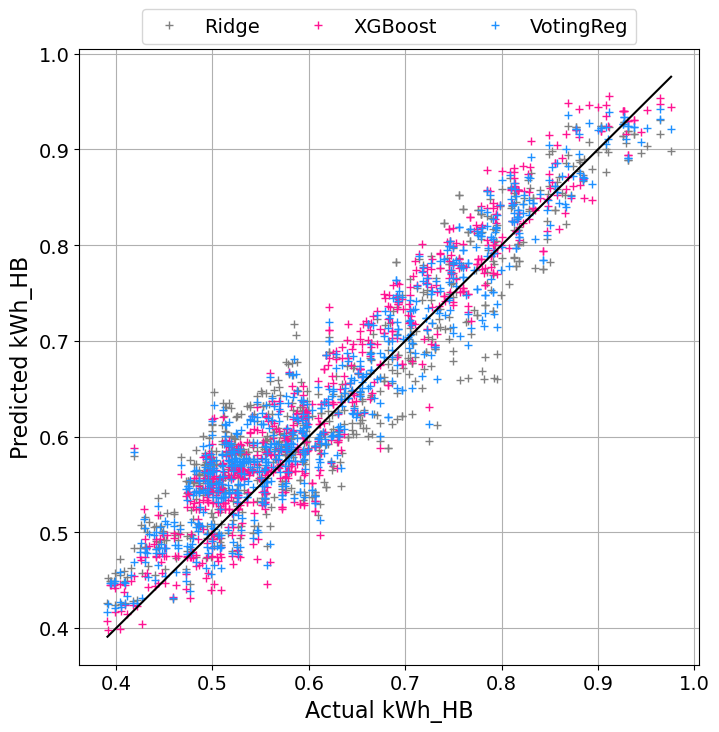

In [27]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])

plt.subplots_adjust(hspace=0.1)

ax0.grid(True)

clrs = ['gray','deeppink','dodgerblue']

# Plot test predictions vs. actual
ct=0
for r in res_list:
    lab = r[3][0].index[0]
    ax0.plot(y_test, r[1], color = clrs[ct], linestyle = '', marker = '+', label=lab)
    ct+=1

ax0.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'k')


ax0.set_ylabel('Predicted kWh_HB', fontsize=16)
ax0.set_xlabel('Actual kWh_HB', fontsize=16)
ax0.tick_params(axis='x', labelsize=14)
ax0.tick_params(axis='y', labelsize=14)
ax0.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4, fontsize=14)